# About
This notebook is the Quantile Regression part of the 2nd place solution, which is a slightly modified version. 

# Setting

In [1]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import random

from tqdm import tqdm_notebook
from plotnine import *
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

import tensorflow as tf
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

import json
import gc

In [2]:
# Setting Seeds
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    
seed_everything(42)

In [3]:
# Load Setting File
json_open = open('../input/settings/settings.json')
SETTINGS = json.load(json_open)

PATH = SETTINGS['PATH']
PARAMS = SETTINGS['PARAMS']
FEATURES = SETTINGS['FEATURES']

print(SETTINGS)

{'PATH': {'ROOT': '../input/', 'TRAIN_CSV_PATH': '../input/osic-pulmonary-fibrosis-progression/train.csv', 'TEST_CSV_PATH': '../input/osic-pulmonary-fibrosis-progression/test.csv', 'SAMPLESUB_CSV_PATH': '../input/osic-pulmonary-fibrosis-progression/sample_submission.csv', 'TRAIN_DATA_DIR': '../input/osic-pulmonary-fibrosis-progression/train/', 'TEST_DATA_DIR': '../input/osic-pulmonary-fibrosis-progression/test/', 'MASK_NOISE_DIR': '../input/osic-pulmonary-fibrosis-progression-lungs-mask/mask_noise/mask_noise/', 'TRAIN_MODEL_WEIGHTS_DIR': '../input/training-osic-2nd-place-code/'}, 'PARAMS': {'MODELS_EFF': [0], 'WEIGHT_EFF': 0.2, 'NFOLDS': 4, 'BATCH_SIZE': 128, 'EPOCHS': 300, 'EARLY_STOPPING': 150, 'NUM_LAST_FVC': 2, 'QS1': 0.2, 'QS2': 0.5, 'QS3': 0.8}, 'FEATURES': ['Sex_Female', 'Sex_Male', 'SmokingStatus_Currently smokes', 'SmokingStatus_Ex-smoker', 'SmokingStatus_Never smoked', 'age', 'percent', 'week', 'min_fvc']}


# Preprocess


## Feature Engineering

In [4]:
# Load Train Data
train_df = pd.read_csv(PATH['TRAIN_CSV_PATH'])
train_df.drop_duplicates(keep=False, inplace=True, subset=['Patient', 'Weeks'])

# Load Test Data
test_df = pd.read_csv(PATH['TEST_CSV_PATH'])
sub_df = pd.read_csv(PATH['SAMPLESUB_CSV_PATH'], usecols = ['Patient_Week', 'Confidence'])
sub_df[['Patient', 'Weeks']] = sub_df['Patient_Week'].apply(lambda x: pd.Series([x.split('_')[0], int(x.split('_')[-1])]))
sub_df = sub_df.merge(test_df.drop('Weeks', axis=1), on='Patient')

train_df['data'] = 'train'
test_df['data'] = 'test'
sub_df['data'] = 'sub'

# Recalculate 'Weeks'
data = train_df.append([test_df, sub_df])
data['min_week'] = data['Weeks']
data.loc[data['data'] == 'sub', 'min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')
data['base_week'] = data['Weeks'] - data['min_week']

# Fix 'Percent' and 'FVC' to the initial values
data_init = data.loc[data['Weeks'] == data['min_week']][['Patient', 'FVC', 'Percent']]
data_init.columns = ['Patient', 'min_FVC', 'min_Percent']
data_init['nb'] = 1
data_init['nb'] = data_init.groupby('Patient')['nb'].transform('cumsum')
data_init = data_init[data_init.nb==1]
data = data.merge(data_init, on='Patient', how='left')

del test_df, data_init
gc.collect()

# One-Hot Encoding ('Sex', 'SmokingStatus')
FE_CATEGORICAL = ['Sex', 'SmokingStatus']
data_categorical = pd.get_dummies(data[FE_CATEGORICAL])
data = pd.concat([data, data_categorical], axis=1)

del data_categorical
gc.collect()

# Min-Max Scaler ('Age', 'FVC', 'Weeks', 'Percent')
data['age'] = (data['Age'] - data['Age'].min()) / (data['Age'].max() - data['Age'].min())
data['min_fvc'] = (data['min_FVC'] - data['min_FVC'].min()) / (data['min_FVC'].max() - data['min_FVC'].min())
data['week'] = (data['base_week'] - data['base_week'].min()) / (data['base_week'].max() - data['base_week'].min())
data['percent'] = (data['min_Percent'] - data['min_Percent'].min()) / (data['min_Percent'].max() - data['min_Percent'].min())

# Split Data
train_df = data.loc[data['data'] == 'train']
sub_df = data.loc[data['data'] == 'sub']

## Cluster Patients


In [5]:
# Linear Regression with the last few FVC
training_patient = train_df[~train_df.duplicated(subset=['Patient'])]

for patient in tqdm_notebook(train_df['Patient'].unique()): 
    idx = train_df['Patient'] == patient
    z = ((train_df.loc[idx, 'FVC'].values[-PARAMS['NUM_LAST_FVC']:] - train_df.loc[idx, 'FVC'].values[-PARAMS['NUM_LAST_FVC']:].mean()) /
         train_df.loc[idx, 'FVC'].values[-PARAMS['NUM_LAST_FVC']:].std())
    reg = LinearRegression(normalize=True,fit_intercept=True).fit(train_df.loc[idx, 'Weeks'].values[-PARAMS['NUM_LAST_FVC']:].reshape(-1,1),z)
    train_df.loc[idx, 'Intercept_2'] = reg.intercept_
    train_df.loc[idx, 'Coef_2'] = reg.coef_[0]
    
training_patient = train_df.drop_duplicates('Patient') 
(ggplot(training_patient) + aes(x='Intercept_2',y='Coef_2',fill='Sex',size='FVC') + geom_point(alpha=0.4) )

# Clustering Patients
cust_array = np.array([training_patient['Intercept_2'].tolist(),training_patient['Coef_2'].tolist()])
cust_array = cust_array.T

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(cust_array)
training_patient['Group'] = clusters.labels_

(ggplot(training_patient) + aes(x='Intercept_2',y='Coef_2',fill='Group') + geom_point(alpha=0.4) )

skf = StratifiedKFold(n_splits=PARAMS['NFOLDS'])
splitter = skf.split(training_patient, training_patient['Group'])

# Training

## Define Model

In [6]:
# Metric
def score(y_true, y_pred):
    C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]

    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)


# Pinball Loss
def qloss(y_true, y_pred, qs1=PARAMS['QS1'], qs2=PARAMS['QS2'], qs3=PARAMS['QS3']):
    # Pinball loss for multiple quantiles
    qs = [qs1, qs2, qs3]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)


# Loss
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss


# Build Model
def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)

    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.8), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

## Train

FOLD 0
train loss:50.62101 score:6.68654
 val  loss:64.57947 score:6.92511


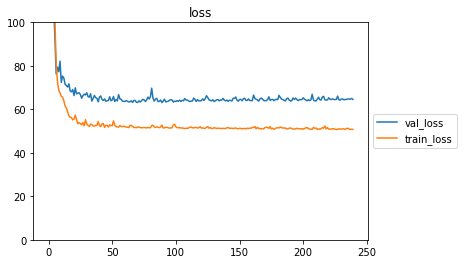

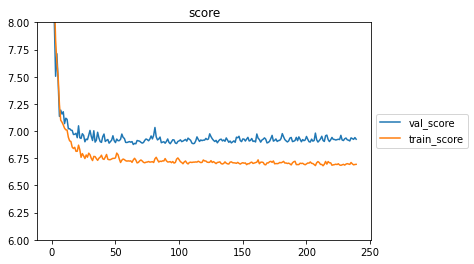

FOLD 1
train loss:46.44034 score:6.58898
 val  loss:85.21814 score:7.35808


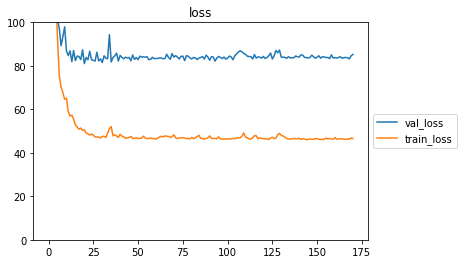

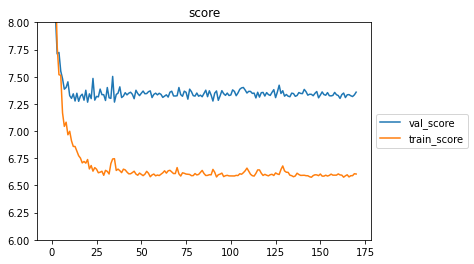

FOLD 2
train loss:51.00124 score:6.67647
 val  loss:63.93175 score:6.89632


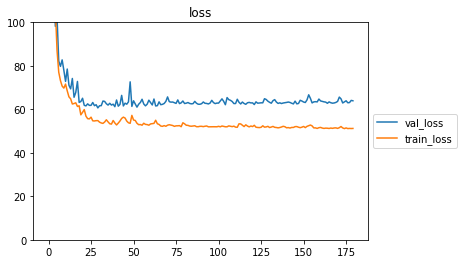

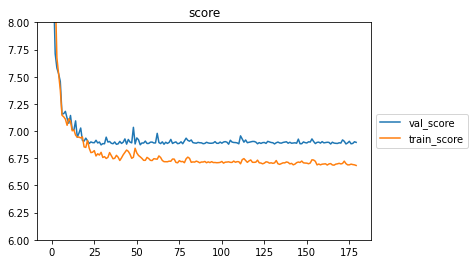

FOLD 3
train loss:50.23916 score:6.67994
 val  loss:63.70005 score:6.90910


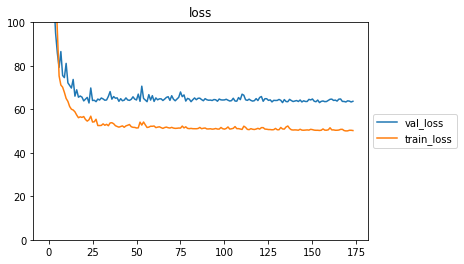

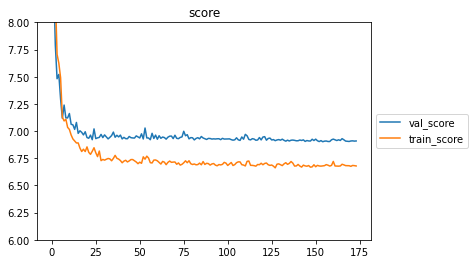

In [7]:
# Prepare for training
y = train_df['FVC'].values.astype('float32')
z_train = train_df[FEATURES].values
z_sub = sub_df[FEATURES].values
nh = z_train.shape[1]
pred_train = np.zeros((z_train.shape[0], 3))
pred_sub = np.zeros((z_sub.shape[0], 3))

# Cross-Validation
for cnt, (tr_idx_pati, val_idx_pati) in enumerate(splitter):
    # Preprocess
    patient_train = training_patient['Patient'].iloc[tr_idx_pati]
    patient_test = training_patient['Patient'].iloc[val_idx_pati]

    tr_idx = train_df['Patient'].isin(patient_train)
    val_idx = train_df['Patient'].isin(patient_test)
    
    data_train = train_df[tr_idx]
    data_val = train_df[val_idx]
    
    data_train = data_train.sort_values(['Patient', 'Weeks'], ascending=True)
    data_val = data_val.sort_values(['Patient', 'Weeks'], ascending=True)
    
    # Choose the last 3 FVC for validation
    tmp = pd.DataFrame(columns = data_val.columns)
    for i in range(3):
        keep_idx = data_val.duplicated(subset=['Patient'], keep='last')
        tmp = tmp.append(data_val[~keep_idx])
        data_val = data_val[keep_idx]
    data_val = tmp
    del tmp
    gc.collect()
                      
    tr_idx = data_train.index
    val_idx = data_val.index   
    
    # Train
    print(f'FOLD {cnt}')
    model = make_model(nh)
    modelCheckpoint = ModelCheckpoint(f'fold{cnt}.h5' , monitor='val_loss', verbose=0, save_best_only = True, save_weights_only=False, mode='auto')
    early_stopping = EarlyStopping(monitor='val_loss', patience=PARAMS['EARLY_STOPPING'], verbose=0, mode='auto')
    stack = model.fit(z_train[tr_idx], y[tr_idx], batch_size=PARAMS['EARLY_STOPPING'], 
                      validation_data=(z_train[val_idx], y[val_idx]), 
                      epochs=PARAMS['EPOCHS'],
                      callbacks=[modelCheckpoint, early_stopping],
                      verbose=0)
     
    # Predict
    pred_train[val_idx] = model.predict(z_train[val_idx], batch_size=PARAMS['EARLY_STOPPING'], verbose=0)
    pred_sub += model.predict(z_sub, batch_size=PARAMS['EARLY_STOPPING'], verbose=0) / PARAMS['NFOLDS']
    
    # Evaluate training
    train_loss, train_score = model.evaluate(z_train[tr_idx], y[tr_idx], verbose=0, batch_size=PARAMS['EARLY_STOPPING'])
    val_loss, val_score = model.evaluate(z_train[val_idx], y[val_idx], verbose=0, batch_size=PARAMS['EARLY_STOPPING'])
    
    # Print loss and score
    print(f'train loss:{train_loss:.5f} score:{train_score:.5f}')
    print(f' val  loss:{val_loss:.5f} score:{val_score:.5f}')

    # Plot loss
    fig=plt.figure()
    plt.plot(stack.history['val_loss'], label="val_loss")
    plt.plot(stack.history['loss'], label="train_loss")
    plt.ylim([0,100])
    plt.title("loss")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.clf()
    plt.close()

    # Plot score
    fig=plt.figure()
    plt.plot(stack.history['val_score'], label="val_score")
    plt.plot(stack.history['score'], label="train_score")
    plt.ylim([6,8])
    plt.title("score")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

## Evaluate

In [8]:
# Calculate Cross-Validation Score
def cal_cv(y_true, y_pred):
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    sigma_clip = np.max(sigma)
    delta = np.abs(y_true[:, 0] - fvc_pred)
    delta = np.min(delta)
    sq2 = np.sqrt(2.)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)


cv_score=0
for id_patient in train_df['Patient'].unique():
    idx_patient = train_df.loc[train_df['Patient'] == id_patient].index
    cv_score += cal_cv(np.array(y[idx_patient]).reshape(-1, 1), pred_train[idx_patient])
cv_score /= len(train_df['Patient'].unique())
print(f"CV score : {cv_score:.5f}")

CV score : 6.54132


# Submission

In [9]:
# Calculate Confidence
sigma_opt = mean_absolute_error(y, pred_train[:, 1])
unc = pred_train[:,2] - pred_train[:, 0]
sigma_mean = np.mean(unc)

sub_df['FVC1'] = pred_sub[:, 1]
sub_df['Confidence1'] = pred_sub[:, 2] - pred_sub[:, 0]
subm = sub_df[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm['FVC1'].isnull()].head(10)

subm.loc[~subm['FVC1'].isnull(),'FVC'] = subm.loc[~subm['FVC1'].isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm['FVC1'].isnull(),'Confidence'] = subm.loc[~subm['FVC1'].isnull(),'Confidence1']

In [10]:
# Make CSV
otest = pd.read_csv(PATH["TEST_CSV_PATH"])
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

subm = subm.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
subm = subm[['Patient_Week', 'FVC', 'Confidence']]
subm.to_csv('submission.csv', index=False)
print(subm.head())

                    Patient_Week          FVC  Confidence
0   ID00419637202311204720264_-1  3005.758972  284.871033
1  ID00419637202311204720264_-10  3039.933167  283.241028
2  ID00419637202311204720264_-11  3043.730347  283.059753
3  ID00419637202311204720264_-12  3047.527527  282.878845
4   ID00419637202311204720264_-2  3009.556152  284.689941
